In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
import copy

import gymnasium as gym

from truco_env import TrucoMineiroEnv, test_game
from truco_players import LearningPlayer, RandomBotPlayer, NetworkBotPlayer, HumanPlayer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
#test_game()

# Deep QLearning

In [4]:
class TransitionBuffer:

    def __init__(self, capacity=1000000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def insert(self, transition):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        assert self.can_sample(batch_size)

        batch = random.sample(self.memory, batch_size)
        batch = zip(*batch)
        return [torch.cat(items) for items in batch]

    def can_sample(self, batch_size):
        return len(self.memory) >= batch_size * 10

    def __len__(self):
        return len(self.memory)

In [5]:
class PlayerBuffer:
    def __init__(self, selection_window):
        self.buffer = []
        self.selection_window = selection_window

    def register(self, player_network):
        self.buffer.append(player_network)
    
    def sample(self, num_players):
        return random.sample(num_players * self.buffer[-self.selection_window:], num_players)

In [6]:
class PreprocessEnv(gym.Wrapper):

    def __init__(self, env):
        gym.Wrapper.__init__(self, env)

    def reset(self, reset_score):
        obs, info = self.env.reset(reset_score=reset_score)

        obs = np.array([*obs["current_player_cards"], obs["other_card"], obs["first_hand_winner"], obs["current_player_score"], obs["other_player_score"], obs["current_bet"], int(obs["trucable"]), int(obs["respond"]), *obs["card_frequency"]], dtype=np.int64)
        obs = torch.from_numpy(obs).unsqueeze(dim=0).float().to(device)

        return obs, info

    def step(self, action):
        obs, reward, done, info = self.env.step(action.item())

        next_state = np.array([*obs["current_player_cards"], obs["other_card"], obs["first_hand_winner"], obs["current_player_score"], obs["other_player_score"], obs["current_bet"], int(obs["trucable"]), int(obs["respond"]), *obs["card_frequency"]], dtype=np.int64)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float().to(device)
        reward = torch.tensor(reward).view(1, -1).float().to(device)
        done = torch.tensor(done).view(1, -1).to(device)

        return next_state, reward, done, info

In [7]:
class DeepQLearning:
    def __init__(self, env, eps, alpha, gamma, transition_batch_size, copy_period, change_period, selection_window, Q_network=None):
        self.env = PreprocessEnv(env)
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.transition_batch_size = transition_batch_size
        if copy_period > change_period: raise Exception("copy_period cannot be grater than change_period!")
        self.copy_period = copy_period
        self.change_period = change_period
        self.selection_window = selection_window
        self.state_dims = self._calculate_state_dims(env)
        self.num_actions = env.action_space.n
        self.num_players = env.num_players
        self._initialize_networks(Q_network)

    def _calculate_state_dims(self, env: TrucoMineiroEnv):
        state_dims = 0
        for i in env.observation_space.values():
            state_dims += 1 if type(i) == gym.spaces.Discrete else len(i)
        return state_dims
    
    def _initialize_networks(self, Q_network=None):
        if Q_network == None:
            self.Q_network = nn.Sequential(
                nn.Linear(self.state_dims, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, self.num_actions)
            ).to(device)
        else:
            self.Q_network = Q_network

        self.target_Q_network = copy.deepcopy(self.Q_network).eval().to(device)

    def _choose_epsgreedy_action(self, state, info):
        valid_actions = info["valid_actions"]

        if np.random.uniform(0, 1) < self.eps:
            action = np.random.choice(valid_actions)
            return torch.tensor(action).view(1, -1).to(device)
        else:
            av = self.Q_network(state).detach()
            action = valid_actions[np.argmax([av[0, valid_action].item() for valid_action in valid_actions])]
            return torch.tensor(action).view(1, -1).to(device)
    

    def run(self, num_episodes):
        optim = AdamW(self.Q_network.parameters(), lr=self.alpha)
        transition_buffer = TransitionBuffer()
        player_buffer = PlayerBuffer(self.selection_window)
        stats = {'MSE Loss': [], 'Returns': [], 'wins': 0, 'winrate': []}

        for episode in tqdm(range(1, num_episodes + 1)):
            state, info = self.env.reset(reset_score=True)
            done = False
            gamma_pot = 1
            ep_return = 0
            while not done:
                action = self._choose_epsgreedy_action(state, info)
                next_state, reward, done, info = self.env.step(action)

                transition_buffer.insert([state, action, reward, done, next_state])

                if transition_buffer.can_sample(self.transition_batch_size):
                    state_b, action_b, reward_b, done_b, next_state_b = transition_buffer.sample(self.transition_batch_size)
                    qsa_b = self.Q_network(state_b).gather(1, action_b)

                    next_qsa_b = self.target_Q_network(next_state_b)
                    next_qsa_b = torch.max(next_qsa_b, dim=-1, keepdim=True)[0]

                    target_b = reward_b + ~done_b * self.gamma * next_qsa_b
                    loss = F.mse_loss(qsa_b, target_b)
                    self.Q_network.zero_grad()
                    loss.backward()
                    optim.step()

                    stats['MSE Loss'].append(loss.item())

                ep_return += reward.item() * gamma_pot
                gamma_pot *= self.gamma
                if info["round_ended"]:
                    next_state, info = self.env.reset(reset_score=False)
                else:
                    state = next_state

            if info['victory']:
                stats['wins'] += 1
            if episode % 100 == 0:
                stats['winrate'].append(stats['wins']/episode)

            stats['Returns'].append(ep_return)

            if episode % 10 == 0:
                self.target_Q_network.load_state_dict(self.Q_network.state_dict())
            
            if episode % self.copy_period == 0:
                player_buffer.register(NetworkBotPlayer(f"Number {episode//self.copy_period} # Episode {episode}", copy.deepcopy(self.Q_network).eval().to(device)))

            if episode % self.change_period == 0:
                sampled_players = player_buffer.sample(self.num_players - 1)
                all_players = [LearningPlayer("deep_qlearning"), *sampled_players]
                self.env.unwrapped.set_players([all_players[0:self.num_players//2], all_players[self.num_players//2:self.num_players]])

        return stats

In [8]:
env = TrucoMineiroEnv(
    num_players=2,
    teams=[[LearningPlayer("deep_qlearning")], [RandomBotPlayer("Aleatório")]]
)

deep_qlearning = DeepQLearning(
    env = env,
    eps = 0.01,
    alpha = 0.1,
    gamma = 0.99,
    transition_batch_size = 32,
    copy_period = 100,
    change_period = 100,
    selection_window = 50,
    Q_network = None
)

stats_deep_qlearning = deep_qlearning.run(num_episodes=(num_episodes:=50000))

100%|██████████| 50000/50000 [25:53<00:00, 32.18it/s]  


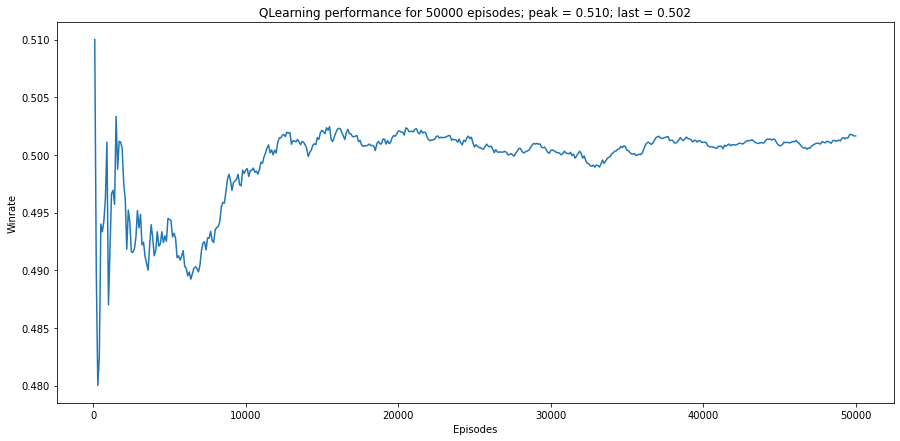

In [9]:
skip = 100
x = [i * skip for i in range(1, num_episodes//skip + 1)]
y = stats_deep_qlearning["winrate"]

plt.figure(figsize=(15, 7))
plt.plot(x, y)
plt.xlabel("Episodes")
plt.ylabel("Winrate")
plt.title(f"QLearning performance for {num_episodes} episodes; peak = {max(y):.3f}; last = {y[-1]:.3f}")
plt.show()